In [1]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
from datetime import datetime
import xgboost as xgb
import seaborn as sns
import itertools
import xarray as xr

import sklearn.metrics
from tqdm import tqdm

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import json
from shapely.geometry import Polygon, LineString, Point

2024-09-06 15:49:11.033289: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-06 15:49:13.741938: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Load Model & Data


In [3]:


main_data = pd.read_feather("data/merged_with_weather.feather")
main_data = main_data[np.isnan(main_data['t2m']) == False]
main_data = main_data[list(main_data.columns[2:12]) + list(main_data.columns[20:])]



In [5]:
prohibited = ["ICOS", "time_stamp", "level_0", "index", "datetime", "value_std_dev", "station_dist", "station_lat", "station_lon", "geometry"]# + ["lat", "lon", "hours_since_2014_1_1"]
predictors = ["lat", "lon", 'OCO2', "hours_since_2014_1_1", 't2m', 'd2m', 'tp', 'swvl1', 'sp', 'u10', 'v10', 'cape', 'skt', 'tcc']
target = "ICOS"
test_stations = ['station_KRE', 'station_SVB', 'station_HEL', 'station_TRN']

print(predictors, "->",  target)

['lat', 'lon', 'OCO2', 'hours_since_2014_1_1', 't2m', 'd2m', 'tp', 'swvl1', 'sp', 'u10', 'v10', 'cape', 'skt', 'tcc'] -> ICOS


In [6]:

train_model = False
date = "2024-06-27 09.37.02"

filtr = sum(main_data[s] for s in test_stations) > 0
train = main_data[filtr == False]
test = main_data[filtr == True]
print(predictors, "->", target)

Xt = train[predictors]
yt = train[target]
Xv = test[predictors]
yv = test[target]

mX = np.mean(Xt, axis=0)
sX = np.std(Xt, axis=0)
sX[sX == 0] = 1
Xt = (Xt-mX)/sX
Xv = (Xv-mX)/sX

my = np.mean(yt)
sy = np.std(yt)
yt = (yt-my)/sy
yv = (yv-my)/sy

# load model from specific date
with open("results/config_" + date + ".json") as f:
    previous_result = json.load(f)
config = previous_result['Neural Network Regression']

model = tf.keras.models.load_model("models/refined_full_model_" + date + ".keras")


['lat', 'lon', 'OCO2', 'hours_since_2014_1_1', 't2m', 'd2m', 'tp', 'swvl1', 'sp', 'u10', 'v10', 'cape', 'skt', 'tcc'] -> ICOS


2024-09-06 15:49:37.700940: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/oskar/Documents/Jupyter/CO2/.conda/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


# Error plots

In [14]:

pred_test = model.predict(Xv).reshape(-1)
pred_test = pred_test*sy + my

3878/3878 ━━━━━━━━━━━━━━━━━━━━ 3s 788us/step


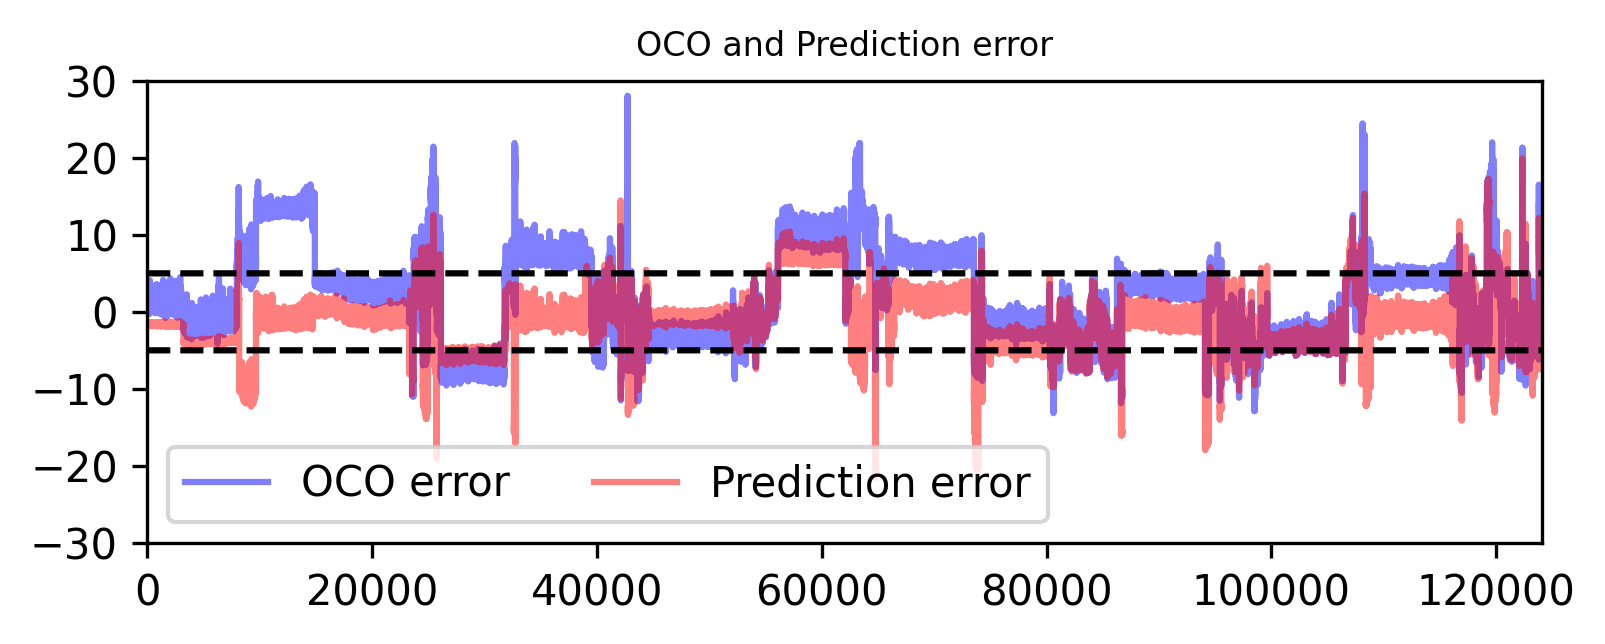

In [18]:
df_test = pd.DataFrame()
df_test['lat'] = test['lat']
df_test['lon'] = test['lon']
df_test['time'] = test['hours_since_2014_1_1']
df_test['ICOS'] = test['ICOS']
df_test['OCO2'] = test['OCO2']
df_test['pred'] = pred_test#

df_test['OCO2_diff'] = (df_test['ICOS'] - df_test['OCO2'])
df_test['pred_diff'] = (df_test['ICOS'] - df_test['pred'])
df_test = df_test.sort_values(by="lat")
df_test = df_test.sort_values(by="lon")
df_test = df_test.sort_values(by="time")


y1 = df_test['OCO2_diff'].values
y2 = df_test['pred_diff'].values
x = range(df_test.shape[0])

plt.figure(figsize=(6, 2), dpi=300)
plt.plot(x, y1, color='blue', alpha=0.5)
plt.plot(x, y2, color='red', alpha=0.5)
plt.plot(x, 5*np.ones(df_test.shape[0]), 'k--')
plt.plot(x, -5*np.ones(df_test.shape[0]), 'k--')
#plt.fill_between(x, -5*np.ones(df_test.shape[0]), 5*np.ones(df_test.shape[0]), alpha=0.5)
plt.xlim(0, df_test.shape[0])
plt.xlim(0, df_test.shape[0])
plt.yticks(np.linspace(-30,30,7))
plt.ylim(-30,30)
plt.title("OCO and Prediction error", fontsize=8)
#plt.ylabel("error")
#plt.xlabel("data point")
plt.legend(["OCO error", "Prediction error"], loc="lower left",ncol=2)

# Shap Analysis

In [28]:
import shap

N = 5000
background = Xt.iloc[np.random.choice(Xt.shape[0], N, replace=False), :].values

# explain predictions of the model on three images
e = shap.DeepExplainer(model, background)

In [ ]:
shap_values = e(Xv.values)

In [ ]:

real_feature_names = {
    "hours_since_2014_1_1": "Time",
    "lat": "Latitude",
    "lon": "Longitude",
    "t2m": "2m temperature", #"2m temperature"
    "u10": "10m u-component wind", #"10m u-component of wind"
    "v10": "10m v-component wind", #"10m v-component of wind"
    "d2m": "Humidity", #"2m dewpoint temperature"
    "cape": "Convective energy",#"Convective available potential energy",
    "tcc": "Cloud coverage", # "Total Cloud Cover"
    "skt": "Surface temperature", #Skin Temperature?
    "sp": "Surface pressure", #surface_pressure
    "swvl1": "Soil water", #"volumetric_soil_water_layer_1"
    "tp": "Total precipitation", #total_precipitation
}
test_background = Xv.rename(real_feature_names, axis=1)
shap_values_df = pd.DataFrame(shap_values.values[:, :, 0], columns=test_background.columns)
shap_importance = shap_values_df.abs().mean().sort_values(ascending=True)

In [ ]:
shap_importance

Total precipitation     0.002690
Convective energy       0.020152
Soil water              0.031348
Cloud coverage          0.032223
Humidity                0.055288
10m v-component wind    0.068867
10m u-component wind    0.081260
Surface pressure        0.086276
Longitude               0.090832
Latitude                0.116660
2m temperature          0.142386
Time                    0.161667
Surface temperature     0.293073
OCO2                    0.434547
dtype: float64

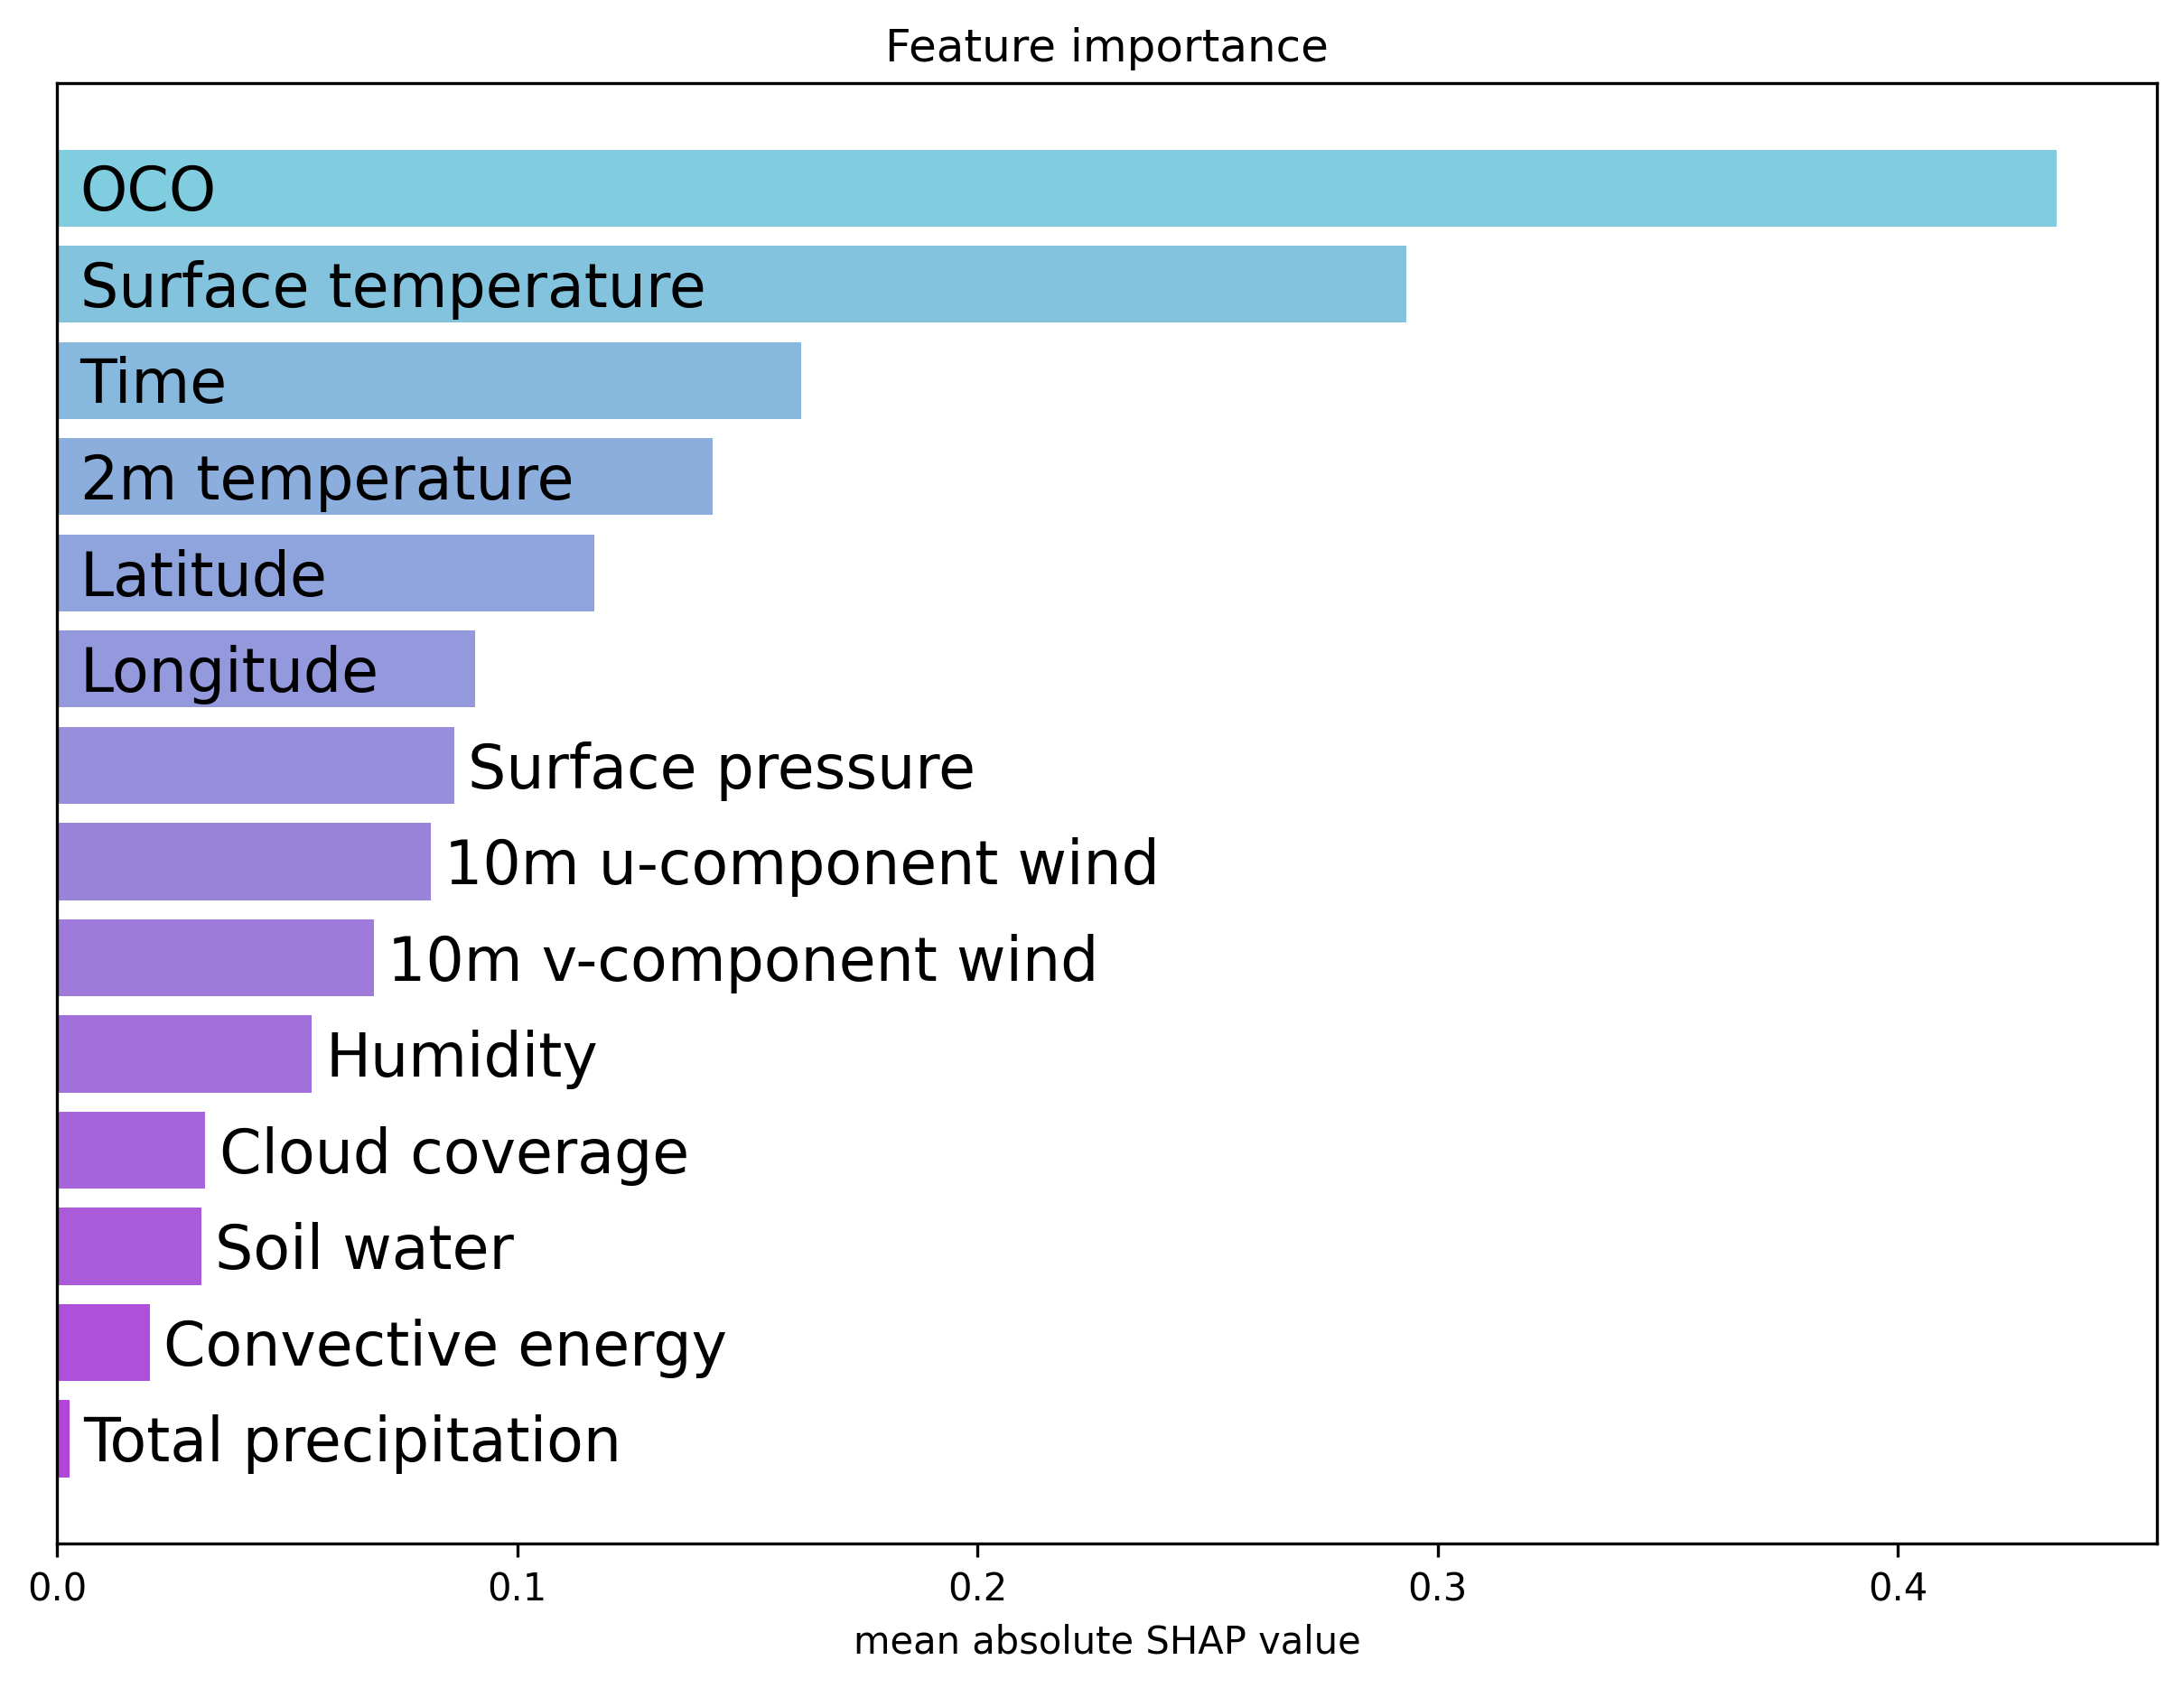

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Sample data
categories = [c.replace("OCO2", "OCO") for c in shap_importance.index]
values = shap_importance

# Generate a custom colormap between purple and blue
colors = ["#B246D9", "#7FCDDE"]  # Purple to blue
cmap = LinearSegmentedColormap.from_list("purple_blue", colors, N=len(values))

# Generate colors from the colormap
num_colors = len(values)
colors = [cmap(i / (num_colors - 1)) for i in range(num_colors)]

# Create a horizontal bar plot
plt.figure(figsize=(10, 7), dpi=300)
bars = plt.barh(categories, values, color=colors)

# Add category names inside the bars
for bar, category in zip(bars, categories):
    x = 0.005
    ha = 'left'
    font_color = 'black'
    if bar.get_width() < 0.09:
        x = bar.get_width() + 0.003
        ha = 'left'
        font_color = 'black'

    plt.text(
        x,  # X position
        bar.get_y() + bar.get_height() / 2 - 0.05,  # Y position
        category,  # Text
        ha=ha,  # Horizontal alignment
        va='center',  # Vertical alignment
        color=font_color,  # Text color
        fontsize=16,  # Font size
        #fontweight='bold'  # Font weight
    )

plt.gca().set_yticklabels([])
plt.gca().set_yticks([])

# Add labels and title
plt.xlabel('mean absolute SHAP value')
plt.title('Feature importance')

# Show the plot
plt.show()


# Measurements

/tmp/ipykernel_1258601/587812840.py:36: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


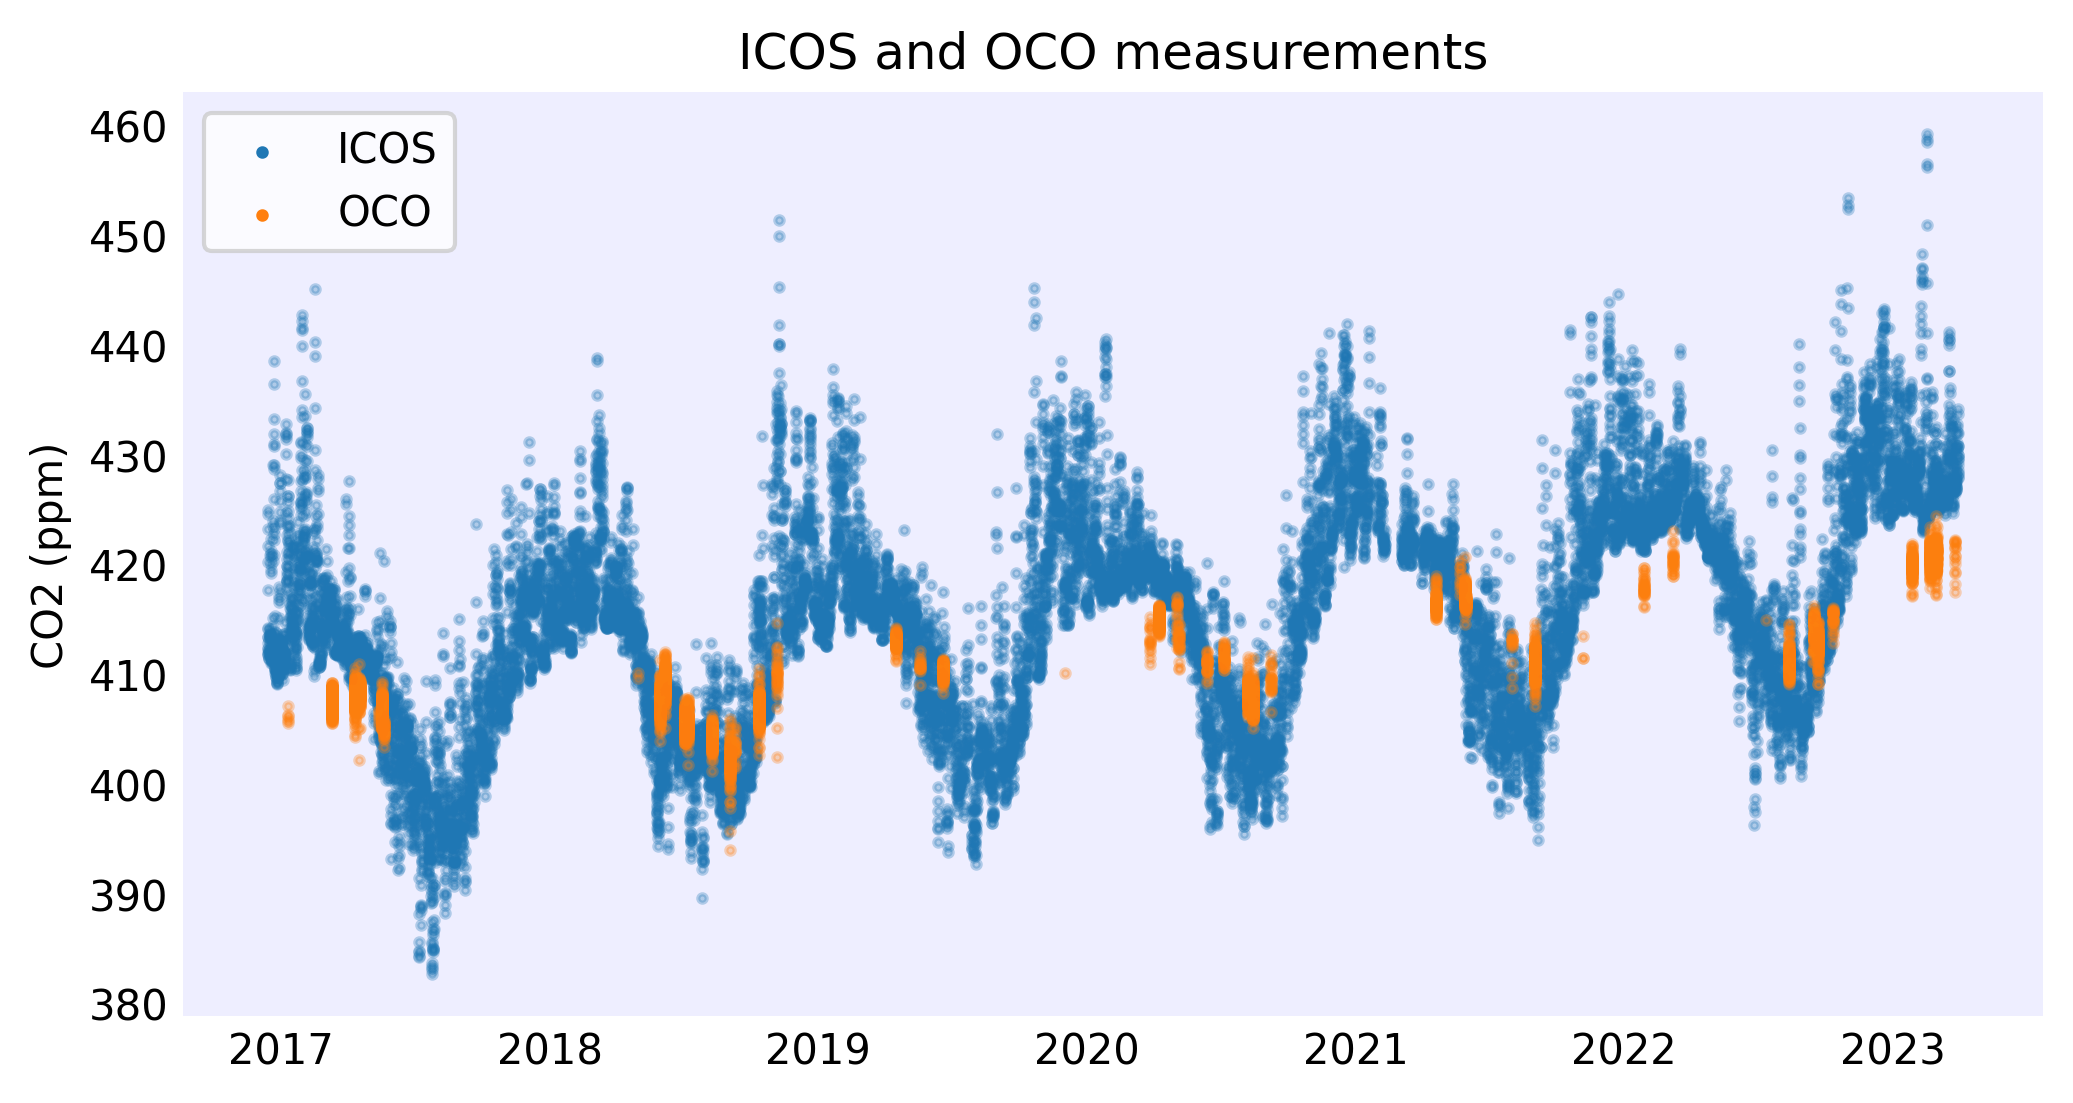

In [49]:
df_oco = pd.read_feather("data/merged_with_weather.feather")
df_icos = pd.read_csv("data/raw/ICOS_CO2_weather_euOct282023.csv")

htm_OCO = df_oco[df_oco['station_HTM'] == 1]
htm_ICOS = df_icos[df_icos['station'] == "HTM"]


plt.figure(figsize=(8,4), dpi=300)

plt.scatter(pd.to_datetime(htm_ICOS['start_time']), htm_ICOS['value'], s=4, alpha=.3)
plt.scatter(pd.to_datetime(htm_OCO['datetime']), htm_OCO['OCO2'], s=4, alpha=.3)

# Set background color to gray
ax = plt.gca()
ax.set_facecolor('#eeeeff')

# Add white grid lines
#plt.grid(color='white', linestyle='-', linewidth=0.7)

# Customize ticks
plt.tick_params(axis='both', which='both', length=0)  # Disable ticks
#plt.tick_params(axis='both', which='major', length=5)  # Enable major ticks with specified length

# Remove the border (spines)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Add labels and title
#plt.xlabel('X-axis')
plt.ylabel('CO2 (ppm)')
plt.title('ICOS and OCO measurements')

legend = plt.legend(["ICOS", "OCO"])
for handle in legend.legendHandles:
    handle.set_alpha(1.0)  # Set opacity to fully opaque (alpha = 1.0)

# Show the plot
plt.show()